In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

from scipy.signal import find_peaks_cwt, find_peaks

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# aggregation indices
os.chdir('/data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA

In [4]:
def read_data(data_dir,t_start=-144):
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset(file_name[0])
    data_2d = xr.open_dataset(file_name[1])
    th = data_zon.th[t_start:,:,:,:]
    qv = data_zon.qv[t_start:,:,:,:]
    u = data_zon.uinterp[t_start:,:,:,:]
    v = data_zon.vinterp[t_start:,:,:,:]
    w = data_zon.winterp[t_start:,:,:,:]
    qc = data_zon.qc[t_start:,:,:,:]
    qi = data_zon.qi[t_start:,:,:,:]
    prs = data_zon.prs[t_start:,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:,:,:]
    pwat = data_2d.pwat[t_start:,:,:]
    cwp = data_2d.cwp[t_start:,:,:]
    cape = data_2d.cape[t_start:,:,:]
    cin = data_2d.cin[t_start:,:,:]
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
    div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
    vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro)

In [88]:
# get weather or weather2 
#server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne'
os.chdir(server)

exp_name = ['CM1_RAD4K_MPI_SFXint',
            'CM1_RAD4K_RCEP_240x240_lowU05',
            'CM1_RAD4K_RCEP_240x240_lowU07',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU12',
            'CM1_RAD4K_RCEP_240x240_lowU15']
fig_dir = server + '/fig_sum/'
print(exp_name)
print('Number of Exp: ', len(exp_name))

['CM1_RAD4K_MPI_SFXint', 'CM1_RAD4K_RCEP_240x240_lowU05', 'CM1_RAD4K_RCEP_240x240_lowU07', 'CM1_RAD4K_RCEP_240x240_lowU10', 'CM1_RAD4K_RCEP_240x240_lowU12', 'CM1_RAD4K_RCEP_240x240_lowU15']
Number of Exp:  6


In [6]:
(th1,T1,qv1,qc1,qi1,rh1,prate1,pwat1,cwp1,u1,v1,w1,div1,vor1,cape1,cin1,prs1,ro1) = read_data(server+'/'+exp_name[0])
(th2,T2,qv2,qc2,qi2,rh2,prate2,pwat2,cwp2,u2,v2,w2,div2,vor2,cape2,cin2,prs2,ro2) = read_data(server+'/'+exp_name[1])
(th3,T3,qv3,qc3,qi3,rh3,prate3,pwat3,cwp3,u3,v3,w3,div3,vor3,cape3,cin3,prs3,ro3) = read_data(server+'/'+exp_name[2])
(th4,T4,qv4,qc4,qi4,rh4,prate4,pwat4,cwp4,u4,v4,w4,div4,vor4,cape4,cin4,prs4,ro4) = read_data(server+'/'+exp_name[3])
(th5,T5,qv5,qc5,qi5,rh5,prate5,pwat5,cwp5,u5,v5,w5,div5,vor5,cape5,cin5,prs5,ro5) = read_data(server+'/'+exp_name[4])
(th6,T6,qv6,qc6,qi6,rh6,prate6,pwat6,cwp6,u6,v6,w6,div6,vor6,cape6,cin6,prs6,ro6) = read_data(server+'/'+exp_name[5])

/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_MPI_SFXint
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU05
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU07
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU10
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU12
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU15


In [7]:
exp_label = ['CTRL','U05','U07','U10','U12','U15']

In [8]:
x_dim = pwat2.lon
y_dim = pwat2.lat
z_dim = T2.lev
t_dim = np.arange(len(T2.time))/72

### Vertical mode decomposition 

In [9]:
tp = th4[-144:,:,65:180,0].mean(('lat','time')) # only the shear region Theta(t,z)
tempp = T4[-144:,:,65:180,0].mean(('lat','time'))
#th_ns = np.concatenate((prec[t,-43:,:],prec[t,:43,:]))

In [10]:
def brunt_vaisala(thetav_prof, z):
    '''construct N^2 = -g/thetav d/dz(thetav)  on the interface levels'''
    N_sq_prof = np.zeros(len(z)+1)
    ggr = 9.81
    #thetav_int = scale2int(thetav_prof,z)
    for i in range(1,len(z)):
        N_sq_prof[i] = ggr/thetav_prof[i] * (thetav_prof[i]-thetav_prof[i-1])/(z[i]-z[i-1])
    N_sq_prof[len(z)] = N_sq_prof[len(z)-1]
    N_sq_prof[0] = N_sq_prof[1]
    return N_sq_prof

In [11]:
def find_vertical_modes(N_sq, zi_full, rigidlid = []):
    '''solve the vertical structure equation d^2/dz^2 W = -\lambda N_sq W \
       and return set of eigenfunctions W_n and eigenvalues \lambda_n
       
       Haertel and Johnson (1998) Two-day disturbances in the equatorial western Pacific.
       Q. J. Meteorol. Soc.''' 
       
    if(rigidlid):
        lid = rigidlid
    else: 
        lid = zi_full[-1]
        
    index = np.where((zi_full<lid) & (zi_full>0))
    zi = zi_full[index]
    Nsqgrd= N_sq[index]
    #set up matrix for interface levels 
    M = np.zeros((len(zi), len(zi))) 
    for i in range(1,len(zi)-1):
        M[i,i] =  -1./(zi[i+1]-zi[i]) - 1./(zi[i]-zi[i-1]) 
        M[i,i-1] = 1./(zi[i]-zi[i-1])
        M[i,i+1] = 1./(zi[i+1]-zi[i])
        M[i,:] = 1./(Nsqgrd[i])*2./(zi[i+1]-zi[i-1])*M[i,:]
        
    #boundary conditions
    M[0,0] = -1./(zi[1]-zi[0]) - 1./(zi[0]-0.)
    M[0,1] = 1./(zi[1]-zi[0]) 
    M[0,:] = 1./(Nsqgrd[0])*2./(zi[1]-0.)*M[0,:]
    M[-1,-1] = - 1./(lid - zi[-1]) - 1./(zi[-1]-zi[-2]) 
    M[-1,-2] = 1./(zi[-1]-zi[-2]) 
    M[-1,:] = 1./(Nsqgrd[-1])*2./(lid -zi[-2])*M[-1,:]
    
    c_w, Z_w = np.linalg.eig(-M) 
    return (c_w,Z_w, zi)

In [35]:
N_sq = brunt_vaisala(tp, z_dim*1000) # brunt_vaisala frequency 

zi_full = np.zeros(len(z_dim)+1)
for i in range(1,len(z_dim)):
    zi_full[i] = 0.5*(z_dim[i]+z_dim[i-1])
zi_full[len(z_dim)]= zi_full[len(z_dim)-1] + (z_dim[len(z_dim)-1]-zi_full[len(z_dim)-2])

C,W,Z = find_vertical_modes(N_sq, zi_full*1000, rigidlid = 15250)
X2 = zip(C,W.transpose())
X_sort2 = sorted(X2,key=lambda val: val[0]) # Eigen vectors

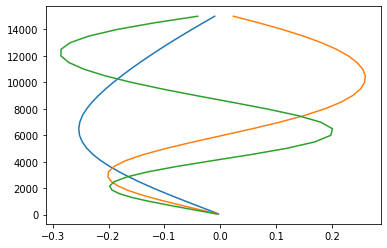

In [36]:
#plt.plot(X_sort2[0][1],Z)
lev = len(X_sort2[1][1])

plt.plot(X_sort2[1][1],Z)
plt.plot(X_sort2[2][1],Z)
plt.plot(X_sort2[3][1],Z)
#plt.ylim([1000,0])

In [39]:
def innerproduct(EIGS,NSQ,ZP,val1,val2):
    ''' calculate the inner product of vertical normal modes val1 and val2 '''
    tot = EIGS[val1][1][0]*EIGS[val2][1][0]*NSQ[0]*(ZP[0])
    for i in range(1,len(ZP)):
        tot = tot + EIGS[val1][1][i]*EIGS[val2][1][i]*NSQ[i]*(ZP[i]-ZP[i-1])
    return tot

In [40]:
def normalize(EIGS,NSQ, ZP, val1):
    ''' ****THIS MIGHT BE THE WRONG THING TO DO****
    returns the normalized eigenfunction for val1''' 
    coeff = 1/np.sqrt(innerproduct(EIGS,NSQ,ZP, val1, val1))
    normalized_eig = coeff * EIGS[val1][1][:]
    return normalized_eig

In [41]:
def project_onto_vertical(var_profile, EIGS, NSQ, ZP,mode):
    '''project an observed profile onto eigenfunction *mode* '''
    eigvec=EIGS[mode][1][:]
    normed_eig = normalize(EIGS,NSQ,ZP, mode)
    
    eigvec = normed_eig
    coeff = eigvec[0]*var_profile[0]*NSQ[0]*(ZP[0])
    for i in range(1,len(ZP)):
        coeff = coeff + eigvec[i]*var_profile[i]*NSQ[i]*(ZP[i]-ZP[i-1])
    projection = coeff*eigvec
    return projection, coeff

In [42]:
def vertical_mode_decomp(theta_profile,w_profile,z,number_mode=5,lid_height=17500):
    N_sq = brunt_vaisala(theta_profile, z)
    
    zi_full = np.zeros(len(z)+1)
    for i in range(1,len(z)):
        zi_full[i] = 0.5*(z[i]+z[i-1])
    zi_full[len(z)]= zi_full[len(z)-1] + (z[len(z)-1]-zi_full[len(z)-2])

    # solve eigenfunctions
    C,W,Z = find_vertical_modes(N_sq, zi_full, rigidlid = lid_height)
    X = zip(C,W.transpose())
    X_sort = sorted(X,key=lambda val: val[0]) # Eigen functions
    
    w_proj_all = [] 
    w_coeff_all = []
    for i in range(0,number_mode): 
        w_proj, w_coeff = project_onto_vertical(w_profile,X_sort,N_sq,Z,i)
        w_proj_all.append(w_proj)
        w_coeff_all.append(w_coeff)
        
    return w_proj_all, w_coeff_all, Z, X_sort

In [43]:
# w_proj_all = [] 
# w_coeff_all = []
# trunc = 10 # number of modes 

# w4_tz = w4[:,:,60:180,0].mean(('time','lat')) # shear region

# for i in range(0,trunc): 
#     w_proj, w_coeff = project_onto_vertical(w4_tz, X_sort2,N_sq,Z,i)
#     w_proj_all.append(w_proj)
#     w_coeff_all.append(w_coeff)
    
# i=0
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), sharey=False)
# for p in w_proj_all: 
#     ax1.plot(p,Z, label='mode '+str(i))
#     i+=1
# ax1.legend(ncol=2,frameon=False)
# # total 
# ax1.plot(w2s_peak[:len(Z)],Z,color='k')
# w_proj_reconst = np.nansum(np.asarray(w_proj_all),axis=0)
# ax1.plot(w_proj_reconst[:len(Z)],Z,'--k')
    
# #legend(loc='lower left')
# speeds=[]
# for i in range(0,trunc):
#     speeds.append(1./np.sqrt(X_sort2[i][0]))
# for i in range(0,trunc):
#     ax2.scatter(speeds[i],np.abs(w_coeff_all[i]), marker = 'o')
# ax2.set_xlabel('c (m/s)')
# ax1.set_title('vertical mode projection')
# ax2.set_title('projection coefficient vs. c')
# ax2.set_ylim([0,np.asarray(w_coeff_all)[1:].max()])

In [ ]:
prate1_ns = np.concatenate((prate1[:,-43:,:],prate1[:,:43,:]),axis=1)

In [ ]:
peak_pos1,peak_values = find_peaks(prate1[-360:,].mean(('lat','lon')),height=12.5) # domaina-averaged peak
peak_pos2,peak_values = find_peaks(prate2[-360:,].mean(('lat','lon')),height=12.5)

In [ ]:
plt.plot(prate1[-360:,].mean(('lat','lon')))
for xpos in peak_pos1:
    plt.vlines(xpos,ymin=10,ymax=20,color='r')
plt.xlim([300,350])

In [ ]:
w1s = w1[-360:,:,65:151,0]
w1ns = np.concatenate((w1[:,:,-43:,0],w1[:,:,:43,0]),axis=2)
w1_tz = w1.mean('lat')
w1s_tz = w1s.mean('lat') # only the shear region Theta(t,z)
w1ns_tz = w1ns.mean(axis=2)

w1s_peak = w1s_tz[peak_pos1,:].mean(axis=0)
w1ns_peak = w1ns_tz[peak_pos1,:].mean(axis=0)
w1full_peak = w1_tz[peak_pos1,:].mean(axis=0)

w2s = w2[-360:,:,65:151,0]
w2ns = np.concatenate((w2[:,:,-43:,0],w2[:,:,:43,0]),axis=2)
w2_tz = w2.mean('lat')
w2s_tz = w2s.mean('lat') # only the shear region Theta(t,z)
w2ns_tz = w2ns.mean(axis=2)

w1s_peak = w1s_tz[peak_pos1,:].mean(axis=0)
w1ns_peak = w1ns_tz[peak_pos1,:].mean(axis=0)

w2s_peak = w2s_tz[peak_pos2,:].mean(axis=0)
w2ns_peak = w2ns_tz[peak_pos2,:].mean(axis=0)
w2full_peak = w1_tz[peak_pos1,:].mean(axis=0)

In [ ]:
factor=10

plt.plot(3600*ro1[0,:,0,0]*w1s_peak,z_dim,'k',label='CTRL_s')
plt.plot(3600*ro1[0,:,0,0]*w1ns_peak,z_dim,'--k',label='CTRL_ns')

plt.plot(3600*ro1[0,:,0,0]*w2s_peak,z_dim,'r',label='U15H2km_s')
plt.plot(3600*ro1[0,:,0,0]*w2ns_peak,z_dim,'--r',label='U15H2km_ns')
plt.legend()
plt.ylim([0,18])
plt.xlabel('Omega [Pa/hr]')

- output for all shear cases 

In [54]:
tp1 = th1[:,:,:,0].mean(('lat','time')) # only the shear region Theta(t,z)
tp2 = th2[:,:,80:160,0].mean(('lat','time')) # only the shear region Theta(t,z)
tp3 = th3[:,:,80:160,0].mean(('lat','time')) # only the shear region Theta(t,z)
tp4 = th4[:,:,80:160,0].mean(('lat','time')) # only the shear region Theta(t,z)
tp5 = th5[:,:,80:160,0].mean(('lat','time')) # only the shear region Theta(t,z)
tp6 = th6[:,:,80:160,0].mean(('lat','time')) # only the shear region Theta(t,z)

w1s_peak = w1[:,:,:,0].mean(('lat','time'))
w2s_peak = w2[:,:,80:160,0].mean(('lat','time'))
w3s_peak = w3[:,:,80:160,0].mean(('lat','time'))
w4s_peak = w4[:,:,80:160,0].mean(('lat','time'))
w5s_peak = w5[:,:,80:160,0].mean(('lat','time'))
w6s_peak = w6[:,:,80:160,0].mean(('lat','time'))

In [55]:
number_mode = 8

w_proj_all = np.empty((len(exp_name),number_mode,38))
w_coeff_all = np.empty((len(exp_name),number_mode))
X_sort_all = np.empty((len(exp_name),number_mode))

for n, (theta_profile, w_profile) in enumerate(zip([tp1,tp2,tp3,tp4,tp5,tp6],
                                                  [w1s_peak,w2s_peak,w3s_peak,w4s_peak,w5s_peak,w6s_peak])):

    w_proj,w_coeff,Z,X_sort = vertical_mode_decomp(theta_profile.values,w_profile.values,z_dim*1000,number_mode,lid_height=15000)
    w_proj_all[n,:,:] = np.asarray(w_proj)
    w_coeff_all[n,:] = np.asarray(w_coeff)
    
    for md in range(number_mode):
        X_sort_all[n,md] = np.asarray(X_sort[md][0])

In [56]:
# idx = np.where(np.isnan(w_coeff_all[3,:])==0)[0]
# print(idx)
# w_coeff_new = np.copy(w_coeff_all)*np.nan
# w_coeff_new[3,:len(idx)] = w_coeff_all[3,idx]
# #w_coeff_all[4,-(number_mode-len(idx)):] = np.nan
# w_coeff_new[3,:]

In [57]:
# rank w_proj_all & w_coeff_all
w_coeff_new = np.copy(w_coeff_all)*np.nan
w_proj_new = np.copy(w_proj_all)*np.nan

for n in range(len(exp_name)):
    idx = np.where(np.isnan(w_coeff_all[n,:])==0)[0]
    print(idx)
    w_coeff_new[n,:len(idx)] = w_coeff_all[n,idx]
    w_proj_new[n,:len(idx),:] = w_proj_all[n,idx,:]

[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]
[1 2 3 4 5 6 7]


In [58]:
ro_1d = ro1[0,:38,:,0].mean(axis=1)

In [59]:
p_dim = prs1[0,:38,:,0].mean(axis=1)

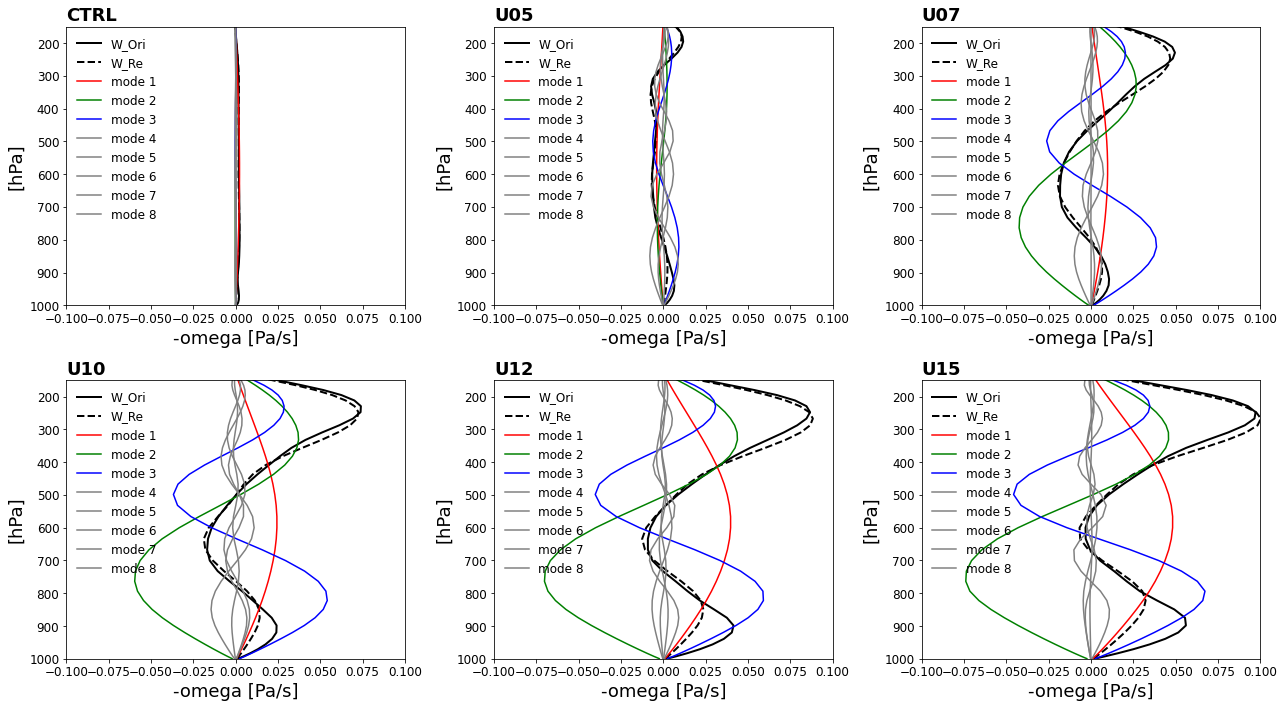

In [89]:
fig, ax = plt.subplots(2,3,figsize=(18,10))
nrow = [0,0,0,1,1,1]
ncol = [0,1,2,0,1,2]
colors = ['r','g','b','grey','grey','grey','grey','grey']

for n,w_ori in enumerate([w1s_peak,w2s_peak,w3s_peak,w4s_peak,w5s_peak,w6s_peak]):   
    # subplots section 
    ax[nrow[n],ncol[n]].plot(9.8*ro_1d*w_ori[:len(p_dim)],p_dim/100,color='k'
                             ,label='W_Ori',linewidth=2)
    w_proj_reconst = np.nansum(np.asarray(w_proj_new[n,:,:]),axis=0)
    ax[nrow[n],ncol[n]].plot(9.8*ro_1d*w_proj_reconst[:len(p_dim)],p_dim/100,'--k'
                             ,label='W_Re',linewidth=2)   
    
    for i in range(number_mode): 
        ax[nrow[n],ncol[n]].plot(9.8*ro_1d*w_proj_new[n,i,:],p_dim/100
                                 ,label='mode '+str(i+1),color=colors[i])

    ax[nrow[n],ncol[n]].legend(frameon=False,loc=2)
    ax[nrow[n],ncol[n]].set_title(exp_label[n],loc='left',fontsize=18,fontweight='bold')
    ax[nrow[n],ncol[n]].set_ylim([1000,150])
    ax[nrow[n],ncol[n]].set_xlabel('-omega [Pa/s]',fontsize=18)
    ax[nrow[n],ncol[n]].set_ylabel('[hPa]',fontsize=18)
    ax[nrow[n],ncol[n]].set_xlim([-0.1,0.1])
    #ax[nrow[n],ncol[n]].grid(linestyle=':',linewidth=1)

plt.tight_layout()
plt.rcParams.update({'font.size':12})

fig.savefig(fig_dir+'vertical_mode_decomposed.pdf',bbox_inches='tight',transparent=False)

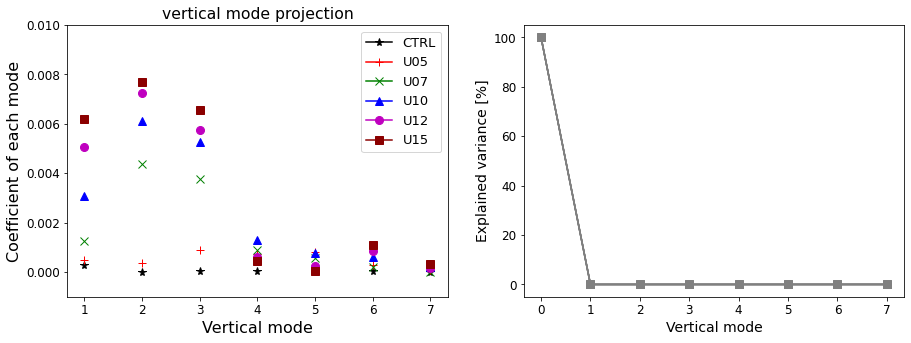

In [90]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

speeds=[]
marker_style = ['*','+','x','^','o','s']
colors = ['k','r','g','b','m','darkred']
#for i in range(0,number_mode):
#    speeds.append(1./np.sqrt(X_sort2[i][0]))

for n in range(len(exp_name)):
    for i in range(number_mode):
        if i == 0:
            ax[0].plot(i+1,np.abs(w_coeff_new[n,i]), marker = marker_style[n], color=colors[n],
                   label=exp_label[n],ms=8)
        else:
            ax[0].plot(i+1,np.abs(w_coeff_new[n,i]), marker = marker_style[n], color=colors[n],ms=8)
    ax[1].plot(np.arange(number_mode),100*X_sort_all[n,:]**2/np.sum(X_sort_all[n,:]**2),
               marker = marker_style[n], color='grey',ms=8)

plt.rcParams.update({'font.size':13})
ax[0].set_xlabel('Vertical mode',fontsize=16)
ax[0].set_ylabel('Coefficient of each mode',fontsize=16)
ax[0].set_title('vertical mode projection')
ax[0].legend()
ax[0].set_ylim([-0.001,0.01])

ax[1].set_xlabel('Vertical mode',fontsize=14)
ax[1].set_ylabel('Explained variance [%]',fontsize=14)

fig.savefig(fig_dir+'vertical_mode_coeff.pdf',bbox_inches='tight',transparent=False)

In [ ]:
p1s_mean = prate1[-360:,65:151,:].mean()
p2s_mean = prate2[-360:,65:151,:].mean()
p3s_mean = prate3[-360:,65:151,:].mean()
p4s_mean = prate4[-360:,65:151,:].mean()
p5s_mean = prate5[-360:,65:151,:].mean()

fig = plt.figure(figsize=(5,5))

for n,(w,prec) in enumerate(zip([w1s_peak,w2s_peak,w3s_peak,w4s_peak,w5s_peak],
                    [p1s_mean,p2s_mean,p3s_mean,p4s_mean,p5s_mean])): 
    plt.plot(3600*-9.8*ro1[0,:,0,0]*w/prec,prs1[0,:,0,0]/100)
plt.ylabel('[km]',fontsize=14)
plt.xlabel('normalzied omega [Pa/hr]/[mm/d]',fontsize=14)
plt.legend(exp_label,frameon=False)
plt.ylim([1000,100]);plt.vlines(0,ymin=0,ymax=18,color='k')
plt.title('Subdomain-averaged omega profile',fontsize=14)

#fig.savefig('subdomain_omega_profile.pdf',bbox_inches='tight',transparent=False)

In [ ]:
p1s_mean = prate1[-360:,65:151,:].mean()
p2s_mean = prate2[-360:,65:151,:].mean()
p3s_mean = prate3[-360:,65:151,:].mean()
p4s_mean = prate4[-360:,65:151,:].mean()
p5s_mean = prate5[-360:,65:151,:].mean()

fig = plt.figure(figsize=(5,5))

for n,(w,prec) in enumerate(zip([w1s_peak,w2s_peak,w3s_peak,w4s_peak,w5s_peak],
                    [p1s_mean,p2s_mean,p3s_mean,p4s_mean,p5s_mean])): 
    plt.plot(w/prec,z_dim)
plt.ylabel('[km]',fontsize=14)
plt.xlabel('normalzied W [m/s]/[mm/d]',fontsize=14)
plt.legend(exp_label,frameon=False)
plt.ylim([0,18]);plt.vlines(0,ymin=0,ymax=18,color='k')
plt.title('W profile',fontsize=14)

### Diagnosed velocity by QR and WTG methodology

In [ ]:
# creating Qr profile 
QR = np.empty(len(z_dim)) # [K/day]
for k,z in enumerate(z_dim):
    if z <= 12:
        QR[k] = -4 # [cooling rate, K/day]
    elif (z > 12) and (z <=15):
        QR[k] = -4*(15-z)/3
    else:
        QR[k] = 0

plt.plot(QR,z_dim)

In [ ]:
# W*dthv/dz = QR, velocity induced by radiative cooling
# here we follow Ramond and Zeng (2005), replacing the observed dthdz
# by 1 K/km as a lower bound as height below 1.5km. 

for n,th in enumerate([th1,th2,th3,th4,th5]):
    th1D = th[-360:,:].mean(axis=(0,2,3))
    dthdz = np.gradient(th1D,z_dim*1000)
    dthdz[dthdz<1/1000] = 1/1000 # [1K/km]
    W_diag = -(QR/86400)/dthdz # [m/s]
    
    # W_diag linearly decreases to 0 at sfc in ABL (1.5km)
    k = np.where(z_dim<=1.5)[0][-1]
    W_diag[:k] = (z_dim[:k]/1.5)*W_diag[k]

    plt.plot(W_diag,z_dim,label=exp_label[n])
    
plt.legend()
plt.xlabel('W induced by cooling [m/s]',fontsize=12)
plt.ylabel('Height [km]',fontsize=12)
plt.xlim([0,0.05])
plt.ylim([0,16])

In [ ]:
# -W*dthv/dz = (th-th_rce)/tau, WTG velocity 
# here we follow Ramond and Zeng (2005), replacing the observed dthdz
# by 1 K/km as a lower bound as height below 1.5km. 
W_diag = np.empty((len(exp_name),len(z_dim))) # 2 means shear and non-shear regimes

fig,ax = plt.subplots(1,2,figsize=(10,5))

for n,th in enumerate([th1,th2,th3,th4,th5]):
    th1D = th[-360:,:].mean(axis=(0,2,3))
    th1D_ref = th1[0,:].mean(axis=(1,2)) # RCE profile 
    dthdz = np.gradient(th1D,z_dim*1000)
    dthdz[dthdz<1/1000] = 1/1000 # [1K/km]
    
    tau = 3600*2 # adjusting time
    W_diag[n,:] = (th1D-th1D_ref)/dthdz/tau # [m/s]
    
    # W_diag linearly decreases to 0 at sfc in ABL (1.5km)
    k = np.where(z_dim<=1.5)[0][-1]
    W_diag[n,:k] = (z_dim[:k]/1.5)*W_diag[n,k]

    ax[1].plot(W_diag[n,:],z_dim,label=exp_label[n])
    ax[0].plot(th1D-th1D_ref,z_dim,label=exp_label[n])
    
ax[0].legend()
ax[0].set_xlabel('$\Delta$theta from RCE',fontsize=12)
ax[0].set_ylabel('Height [km]',fontsize=12)
ax[1].set_xlabel('W induced by cooling [m/s]',fontsize=12)
ax[1].set_ylabel('Height [km]',fontsize=12)
#plt.xlim([0,0.05])
ax[0].set_ylim([0,18])
ax[1].set_ylim([0,18])

In [ ]:
def W_diag_WTG(th1D,th1D_ref,z,tau):
    "diagnosing vertical velocity by WTG"
    
    dthdz = np.gradient(th1D,z*1000)
    dthdz[dthdz<1/1000] = 1/1000 # [1K/km]
    
    W_diag = (th1D-th1D_ref)/dthdz/tau # [m/s]
    
    # W_diag linearly decreases to 0 at sfc in ABL (1.5km)
    k = np.where(z<=1.5)[0][-1]
    W_diag[:k] = (z[:k]/1.5)*W_diag[k]

    return W_diag

In [ ]:
# -W*dthv/dz = (th-th_rce)/tau, WTG velocity 
# here we follow Ramond and Zeng (2005), replacing the observed dthdz
# by 1 K/km as a lower bound as height below 1.5km. 
W_diag = np.empty((len(exp_name),len(z_dim),2)) # 2 means shear and non-shear regimes

fig,ax = plt.subplots(1,2,figsize=(10,5))

for n,th in enumerate([th1,th2,th3,th4,th5]):
    th1D_s = th[-360:,:,80:160,:].mean(axis=(0,2,3))
    th1D_ns = th[-360:,:,0:40,:].mean(axis=(0,2,3))
    th1D_ref = th1[0,:].mean(axis=(1,2)) # RCE profile 

    W_diag[n,:,0] = W_diag_WTG(th1D_s,th1D_ref,z_dim,3600*2) # shear part, upwelling?
    W_diag[n,:,1] = W_diag_WTG(th1D_ns,th1D_ref,z_dim,3600*2) # non-shear, downwelling?

    ax[1].plot(W_diag[n,:,0],z_dim,label=exp_label[n]+'_s')
    ax[1].plot(W_diag[n,:,1],z_dim,label=exp_label[n]+'_ns',linestyle='--')
    ax[0].plot(th1D_s-th1D_ref,z_dim,label=exp_label[n]+'_s')
    ax[0].plot(th1D_ns-th1D_ref,z_dim,label=exp_label[n]+'_ns',linestyle='--')
    
ax[0].legend()
ax[0].set_xlabel('$\Delta$theta from RCE',fontsize=12)
ax[0].set_ylabel('Height [km]',fontsize=12)
ax[1].set_xlabel('W induced by cooling [m/s]',fontsize=12)
ax[1].set_ylabel('Height [km]',fontsize=12)
#plt.xlim([0,0.05])
ax[0].set_ylim([0,18])
ax[1].set_ylim([0,18])